## <p style="text-align: center;">Исследование аномалий в multivariate time-series при помощи вариационных автокодировщиков на базе TCN и трансформеров</p>

### План работы: 

1. Построение и обучение вариационного автокодировщика на базе: 
- линейной модели
- модели на базе TCN (Temporal Convolution Network - имплементация из библиотеки [Darts](https://github.com/unit8co/darts#installation-guide))
- транфсорфмеров (из PyTorch)
2. Обучение модеели VAE на fault free (healthy) data. Подбор гиперпараметров.
3. Выявление аномалий и составление датасета для классификации аномалий по маркированному датасету.
4. Подсчет метри Precision и Recall для тестового датасета в задаче классификации аномалий.
5. Выводы, сравнение с бенчмарками.

Данные:
[Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

In [1]:
!pip install pyreadr

     |████████████████████████████████| 361 kB 4.8 MB/s 


In [2]:
from itertools import chain
from collections import defaultdict
import requests
import pandas as pd
import numpy as np
import pyreadr
import pickle
import torch
from torch import nn
from torch.optim import Adam, RMSprop
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from scipy.stats import norm
from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
open('tcn_model.py', 'w').write(requests.get('https://raw.githubusercontent.com/AlexShevchuk7/MADE/master/Diploma/tcn_model.py').text)
open('TEP_FaultFree_Training.RData', 'wb').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/TEP_FaultFree_Training.RData?raw=true').content)
open('testdata.csv', 'w').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/test_dataset.csv?raw=true').text)
open('extratestdata.csv', 'w').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/extra_test_dataset.csv?raw=true').text)

19245434

In [4]:
from tcn_model import TCNModel

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
class TSDataset(Dataset):
    def __init__(self, data, window, lag):
        self.data = torch.Tensor(data)
        self.window = window
        self.lag = lag
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index * self.lag : index * self.lag + self.window]
        return x
 
    def __len__(self):
        return (len(self.data) -  self.window) // self.lag + 1
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [27]:
class TCNEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNEncoder, self).__init__()
        tcn1 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1]).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=10, input_chunk_length=maxpool1.shape[1], output_chunk_length=maxpool1.shape[1])
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(maxpool1.shape[1]).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
                
        input_dim = maxpool2.shape[1] * maxpool2.shape[2]
        self.out = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)

        flat_embedding = torch.flatten(maxpool2, start_dim=1)
        
        out = F.relu(self.out(flat_embedding))
        
        return out

In [86]:
class TCNVAEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNVAEncoder, self).__init__()
        tcn1 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1]).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=10, input_chunk_length=maxpool1.shape[1], output_chunk_length=maxpool1.shape[1])
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(maxpool1.shape[1]).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
                
        input_dim = maxpool2.shape[1] * maxpool2.shape[2]
        self.mu = nn.Linear(input_dim, latent_dim)
        self.logvar = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)

        flat_embedding = torch.flatten(maxpool2, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logvar = F.relu(self.logvar(flat_embedding))
        
        return mu, logvar

In [87]:
class TCNVAEncoderL(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNVAEncoderL, self).__init__()
        w = batch.shape[1]
        tcn1 = TCNModel(num_filters=30, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(w).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=20, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(w).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3 = TCNModel(num_filters=10, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model3 = tcn3._create_model(maxpool2).to(device)
        tcn3_out = self.tcn_model3(maxpool2)
        
        self.batchnorm3 = nn.BatchNorm1d(w).to(device)
        self.maxpool3 = nn.MaxPool1d(5, stride=3)
        
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)
                
        input_dim = w * maxpool3.shape[2]
        self.mu = nn.Linear(input_dim, latent_dim)
        self.logvar = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3_out = self.tcn_model3(maxpool2)
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)

        flat_embedding = torch.flatten(maxpool3, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logvar = F.relu(self.logvar(flat_embedding))
        
        return mu, logvar

In [88]:
class TCNDecoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNDecoder, self).__init__()
        self.batch_shape = batch.shape
        
        self.linear = nn.Linear(latent_dim, batch.shape[1] * batch.shape[2] // 2)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1])
        
        tcn1 = TCNModel(num_filters=10, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch[:, :, :batch.shape[2] // 2]).to(device)

        self.upsample = nn.Upsample(batch.shape[2])
        self.batchnorm2 = nn.BatchNorm1d(batch.shape[1])

        tcn2 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model2 = tcn2._create_model(batch).to(device)
    
    def forward(self, x):
        x = self.linear(x).reshape(-1, self.batch_shape[1], self.batch_shape[2] // 2)
        x = self.batchnorm1(x)
        x = self.tcn_model1(x)
        x = self.upsample(x)
        x = self.batchnorm2(x)
        x = self.tcn_model2(x)    
        
        return x

In [9]:
class TCNEncoderL(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNEncoderL, self).__init__()
        w = batch.shape[1]
        tcn1 = TCNModel(num_filters=30, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(w).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=20, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(w).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3 = TCNModel(num_filters=10, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model3 = tcn3._create_model(maxpool2).to(device)
        tcn3_out = self.tcn_model3(maxpool2)
        
        self.batchnorm3 = nn.BatchNorm1d(w).to(device)
        self.maxpool3 = nn.MaxPool1d(5, stride=3)
        
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)
                
        input_dim = w * maxpool3.shape[2]
        self.out = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3_out = self.tcn_model3(maxpool2)
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)

        flat_embedding = torch.flatten(maxpool3, start_dim=1)
        
        out = F.relu(self.out(flat_embedding))
        
        return out

In [89]:
class TCNDecoderL(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNDecoderL, self).__init__()
        w = batch.shape[1]
        self.batch_shape = batch.shape
        
        self.linear = nn.Linear(latent_dim, w * batch.shape[2] // 4)
        self.batchnorm1 = nn.BatchNorm1d(w)
        
        tcn1 = TCNModel(num_filters=10, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model1 = tcn1._create_model(batch[:, :, :batch.shape[2] // 4]).to(device)

        self.upsample1 = nn.Upsample(batch.shape[2] // 2)
        self.batchnorm2 = nn.BatchNorm1d(w)

        tcn2 = TCNModel(num_filters=20, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model2 = tcn2._create_model(batch[:, :, :batch.shape[2] // 2]).to(device)
        
        self.upsample2 = nn.Upsample(batch.shape[2])
        self.batchnorm3 = nn.BatchNorm1d(w)

        tcn3 = TCNModel(num_filters=30, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model3 = tcn3._create_model(batch).to(device)
    
    def forward(self, x):
        x = self.linear(x).reshape(-1, self.batch_shape[1], self.batch_shape[2] // 4)
        x = self.batchnorm1(x)
        x = self.tcn_model1(x)
        x = self.upsample1(x)
        x = self.batchnorm2(x)
        x = self.tcn_model2(x)
        x = self.upsample2(x)
        x = self.batchnorm3(x)
        x = self.tcn_model3(x)
        
        return x

In [7]:
class TCNEncoderAtt(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNEncoderAtt, self).__init__()
        tcn1 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1]).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=10, input_chunk_length=maxpool1.shape[1], output_chunk_length=maxpool1.shape[1])
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        input_dim = tcn2_out.shape[2]
        
        self.batchnorm2 = nn.BatchNorm1d(maxpool1.shape[1]).to(device)
        
        self.Queries = nn.Linear(input_dim, latent_dim)
        self.Values = nn.Linear(input_dim, latent_dim)
        self.Keys = nn.Linear(input_dim, latent_dim)
        self.attention = nn.MultiheadAttention(latent_dim, 4, batch_first=True)
            
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        
        q = self.Queries(batchnorm2)
        v = self.Values(batchnorm2)
        k = self.Keys(batchnorm2)
        
        attn = self.attention(q, k, v, need_weights=False)[0]

        out = F.relu(attn)
        
        return out

In [8]:
class TCNDecoderAtt(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNDecoderAtt, self).__init__()
        self.batch_shape = batch.shape
        
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1])
        
        tcn1 = TCNModel(num_filters=10, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch[:, :, :latent_dim]).to(device)

        self.upsample = nn.Upsample(batch.shape[2])
        self.batchnorm2 = nn.BatchNorm1d(batch.shape[1])

        tcn2 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model2 = tcn2._create_model(batch).to(device)
    
    def forward(self, x):
        x = self.batchnorm1(x)
        x = self.tcn_model1(x)
        x = self.upsample(x)
        x = self.batchnorm2(x)
        x = self.tcn_model2(x)    
        
        return x

In [11]:
class TransformEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformEncoder, self).__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=52, nhead=4, dim_feedforward=512, batch_first=True)
        self.transformer = nn.modules.TransformerEncoder(self.encoder_layer, num_layers=8)
                             
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.out = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.transformer(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        out = F.relu(self.out(flat_embedding))
        
        return out, embedding

In [12]:
class TransformVAEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformVAEncoder, self).__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=52, nhead=4, dim_feedforward=256)
        self.transformer = nn.modules.TransformerEncoder(self.encoder_layer, num_layers=8)
                             
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.transformer(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma, embedding

In [13]:
class TransformDecoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformDecoder, self).__init__()
        
        self.batch_shape = batch.shape
        self.linear = nn.Linear(latent_dim, batch.shape[1] * batch.shape[2])
        tdecoderlayer = nn.TransformerDecoderLayer(d_model=52, nhead=4, dim_feedforward=512, batch_first=True)
        self.decoder = nn.modules.TransformerDecoder(tdecoderlayer, num_layers=8)
    
    def forward(self, x, memory):
        tgt = self.linear(x).reshape(-1, self.batch_shape[1], self.batch_shape[2])
        decoded = self.decoder(tgt, memory)
        
        return decoded

In [14]:
class TAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(TAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x, memory = self.encoder(x)
        decoder_out = self.decoder(x, memory)
        return decoder_out

In [15]:
class TVAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(TVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.mu = None
        self.std = None
        
    def sample_z(self, mu, std):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor).to(self.device)
        z = mu + std * epsilon
        return z
    
    def forward(self, x):
        self.mu, logvar, memory = self.encoder(x)
        self.std = torch.exp(0.5 * logvar)
        z = self.sample_z(self.mu.to(self.device), self.std.to(self.device))
        decoder_out = self.decoder(z, memory)
        return decoder_out, self.mu, logvar

In [9]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        decoder_out = self.decoder(self.encoder(x))
        return decoder_out

In [90]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.mu = None
        self.std = None
        
    def sample_z(self, mu, std):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor).to(self.device)
        z = mu + std * epsilon
        return z
    
    def forward(self, x):
        self.mu, logvar = self.encoder(x)
        self.std = torch.exp(0.5 * logvar)
        z = self.sample_z(self.mu.to(self.device), self.std.to(self.device))
        decoder_out = self.decoder(z)
        return decoder_out, self.mu, logvar

### Считывание обучающих анных. Формирование dataloader

In [10]:
train_data = pyreadr.read_r('TEP_FaultFree_Training.RData')

In [11]:
for items in train_data.items():
    tsdata = items[1]

In [ ]:
tsdata.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [12]:
scaler = StandardScaler()
minmax = MinMaxScaler()

signal = tsdata.iloc[:, 3:] 
mm_train_signal = minmax.fit_transform(signal)

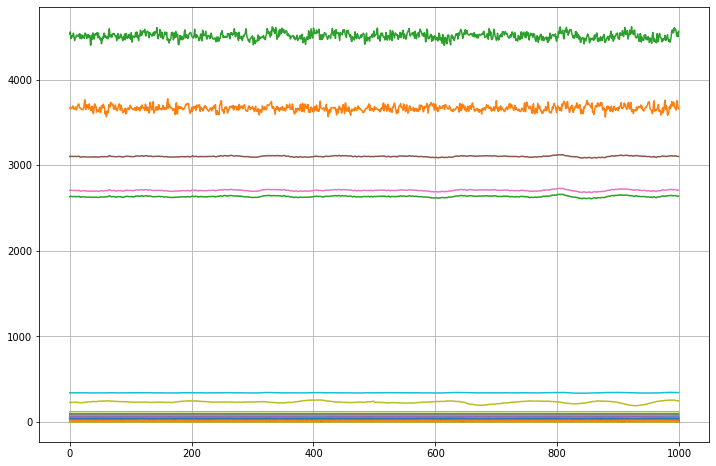

In [ ]:
plt.figure(figsize=(12, 8))
plt.grid()

for i in range(52):
    plt.plot(signal.iloc[:1000, i])
    
plt.show()

In [45]:
batch_size = 32
window = 25
lag = 5    

dataset = TSDataset(mm_train_signal, window, lag)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [46]:
# Первый батч потребуется для конфигурирования архитектур сетей энкодера / декодера
for batch in trainloader:
    break

batch = batch.to(device)

### Считывание тестовых данных

In [15]:
testdata = pd.read_csv('testdata.csv')
extratestdata = pd.read_csv('extratestdata.csv')

In [16]:
testdata = pd.concat([testdata, extratestdata], axis=0)

In [17]:
def faulty_set(fault, max_len):
    window = 64
    limit = (max_len // window) * window
    
    healthy_anomaly = []
    labels = []
    
    mm_healthy = mm_train_signal[:max_len]
    mm_faulty = minmax.fit_transform(testdata[testdata['faultNumber'] == fault].iloc[:, 4:])
    
    for i in range(max_len // 1000):
        healthy_fraction = mm_healthy[i * 500: (i + 1) * 500]
        healthy_anomaly.append(healthy_fraction)
        labels += [0] * len(healthy_fraction)

        faulty_fraction = mm_faulty[i * 500: (i + 1) * 500]
        healthy_anomaly.append(faulty_fraction)
        labels += [1] * len(faulty_fraction)
            
    return np.vstack(healthy_anomaly), labels

In [26]:
testdata.shape

(100000, 56)

### Обучение автокодировщика на данных без аномалий

###TCN

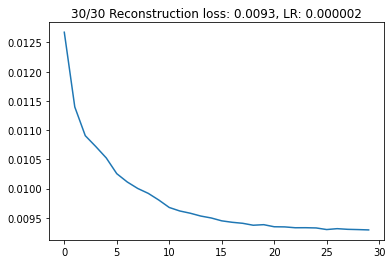

In [47]:
loss_vals = []
name = 'ArtTcn_ae'
learning_rate = 1e-4
n_epochs = 30
latent_dim = 16

encoder = TCNEncoderAtt(batch, latent_dim=latent_dim)
decoder = TCNDecoderAtt(batch, latent_dim=latent_dim)
autoencoder = AE(encoder, decoder)
autoencoder = autoencoder.to(device)

mse = nn.MSELoss()
#opt = Adam(autoencoder.parameters(), lr=learning_rate)
opt = RMSprop(autoencoder.parameters(), lr=learning_rate)
scheduler = MultiStepLR(opt, milestones=[5, 10, 15, 20, 25, 30], gamma=0.5)
#mse = MSELoss()

for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader): 
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits = autoencoder(batch)

        loss = mse(logits, batch)
        loss.backward()
        opt.step()

    loss_vals.append(loss.item())
    scheduler.step()
    curr_lr = opt.param_groups[0]["lr"]

    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Reconstruction loss: {:.4f}, LR: {:.6f}'.format(i+1, n_epochs, loss_vals[-1], curr_lr))
    plt.show();
    clear_output(wait=True)

torch.save(autoencoder.state_dict(), name + '_e' + str(i + 1) + '_lr' + str(learning_rate) + '_win' + str(window) +
            '_b' + str(batch.shape[0]) + '_lat' + str(latent_dim) + '.pkl')

###Transformer

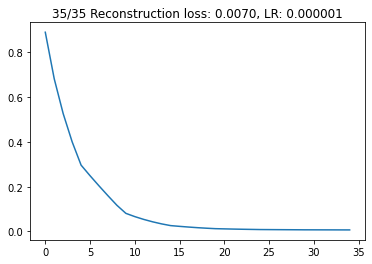

In [55]:
loss_vals = []
name = 'transformer_ae'
learning_rate = 1e-4
n_epochs = 35
latent_dim = 16

encoder = TransformEncoder(batch, latent_dim=latent_dim)
decoder = TransformDecoder(batch, latent_dim=latent_dim)
autoencoder = TAE(encoder, decoder)
autoencoder = autoencoder.to(device)
criterion = nn.MSELoss()
opt = Adam(autoencoder.parameters(), lr=learning_rate)
scheduler = MultiStepLR(opt, milestones=[5, 10, 15, 20, 25, 30, 35], gamma=0.5)
mse = MSELoss()

autoencoder.train()

for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader): 
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits = autoencoder(batch)

        loss = mse(logits, batch)
        loss.backward()
        opt.step()

    loss_vals.append(loss.item())
    scheduler.step()
    curr_lr = opt.param_groups[0]["lr"]

    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Reconstruction loss: {:.4f}, LR: {:.6f}'.format(i+1, n_epochs, loss_vals[-1], curr_lr))
    plt.show();
    clear_output(wait=True)

torch.save(autoencoder.state_dict(), name + '_e' + str(i) + '_lr' + str(learning_rate) + '_win' + str(window) +
            '_b' + str(batch.shape[0]) + '_lat' + str(latent_dim) + '.pkl')

### Обучение вариационного автокодировщика на данных без аномалий

In [115]:
np.tile(np.linspace(0, 1.4, 15), 2)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ,
       1.1, 1.2, 1.3, 1.4])

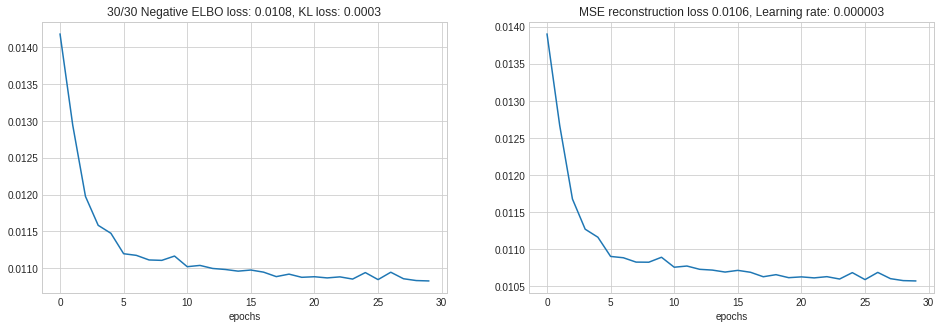

In [121]:
kldivs = []
mses = []
loss_vals = []
name = 'Ltcn_vae'
learning_rate = 1e-4
n_epochs = 30
latent_dim = 16
beta = 1 #np.tile(np.linspace(0, 1.4, 15), 2)

encoder = TCNVAEncoder(batch, latent_dim=latent_dim)
decoder = TCNDecoder(batch, latent_dim=latent_dim)
#encoder = TransformVAEncoder(batch, latent_dim=latent_dim)
#decoder = TransformDecoder(batch, latent_dim=latent_dim)
vae = VAE(encoder, decoder)
vae = vae.to(device)
#opt = RMSprop(vae.parameters(), lr=learning_rate)
opt = Adam(vae.parameters(), lr=learning_rate)
scheduler = MultiStepLR(opt, milestones=[5, 10, 15, 20, 25, 30], gamma=0.5)
mse = MSELoss()


for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader):
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits, mu, logvar = vae(batch)

        reconstruction_loss = mse(logits, batch)

        kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
        loss = reconstruction_loss + kl_loss
        
        loss.sum().backward()
        opt.step()

    mses.append(reconstruction_loss.item())
    kldivs.append(kl_loss)
    loss_vals.append(loss.item())
    curr_lr = opt.param_groups[0]["lr"]
    scheduler.step()

    plt.figure(figsize=(16, 5))
    plt.style.use('seaborn-whitegrid')

    plt.subplot(1, 2, 1)
    plt.title('{}/{} Negative ELBO loss: {:.4f}, KL loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1], kl_loss))
    plt.xlabel("epochs")
    plt.plot(loss_vals[-100:])

    plt.subplot(1, 2, 2)
    plt.plot(mses[-100:])
    plt.title("MSE reconstruction loss {:.4f}, Learning rate: {:.6f}".format(mses[-1], curr_lr))
    plt.xlabel("epochs")

    plt.show()
    clear_output(wait=True)

torch.save(vae.state_dict(), name + '_e' + str(i + 1) + '_lr' + str(learning_rate) + '_win' + str(window) +
            '_b' + str(batch_size) + '_beta' + str(beta) + '_lat' + str(latent_dim) + '.pkl')

In [53]:
mses.append(reconstruction_loss.item())

### Выявление аномалий через вычисление ошибки реконструкции сигнала

###TCN

Per sample loss and metrics evaluation

In [35]:
# Per sample losses distribution
window = 25
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch = autoencoder(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    eval_losses = eval_losses + mse.tolist()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.019315872579813008

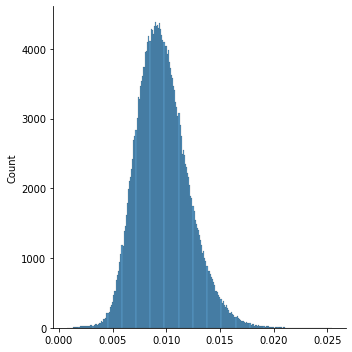

In [37]:
sns.displot(np.stack(eval_losses))

In [38]:
test_recall = []
test_precision = []
window = 25
maxlen = 10000
row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

iterations = 10000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, maxlen)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            per_fault_loss = np.append(per_fault_loss, mse.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true, per_fault_loss))
    test_precision.append(precision_score(y_true, per_fault_loss)) #[: iterations * window]
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.3792,0.997370
1,0.9906,0.998992
2,0.2036,0.995112
3,0.3072,0.996755
4,0.1194,0.991694
5,1.0000,0.999001
6,0.1052,0.990584
7,0.3658,0.997274
8,0.2000,0.995025
9,0.1328,0.992526


In [39]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.36137, 0.9958407520022728)

Per window fault distribution estimation for Autoencoder

In [48]:
# Per window fault distribution estimation
window = 25
eval_losses = []
mse = MSELoss()
#row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

for k in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[k * window: k * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch = autoencoder(batch)
        
    loss = mse(reconstructed_batch, batch)
    eval_losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.012030950258485985

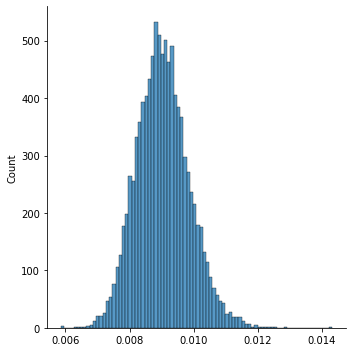

In [50]:
sns.displot(np.stack(eval_losses))

In [53]:
test_recall = []
test_precision = []
window = 25
mse = MSELoss()
autoencoder.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            loss = mse(reconstructed_batch, batch)
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,1.000,1.0
1,1.000,1.0
2,1.000,1.0
3,1.000,1.0
4,0.820,1.0
5,1.000,1.0
6,0.265,1.0
7,0.875,1.0
8,1.000,1.0
9,0.925,1.0


In [54]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.90175, 1.0)

### Variational autoencoder - evaluation section

TCN

In [56]:
# Per sample losses distribution
window = 25
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

vae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = vae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    eval_losses = eval_losses + mse.tolist()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.02144453859329227

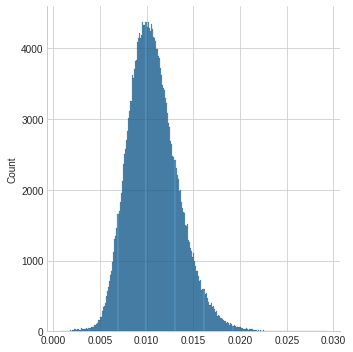

In [58]:
sns.displot(np.stack(eval_losses))

In [59]:
test_recall = []
test_precision = []
window = 25
maxlen = 10000
row_wise_mse = nn.MSELoss(reduction='none')

vae.eval()

iterations = 10000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, maxlen)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = vae(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            per_fault_loss = np.append(per_fault_loss, mse.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true, per_fault_loss))
    test_precision.append(precision_score(y_true, per_fault_loss)) #[: iterations * window]
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.4222,0.994816
1,0.9922,0.997788
2,0.1968,0.990937
3,0.2624,0.990937
4,0.1894,0.991623
5,1.0000,0.998004
6,0.2456,0.991122
7,0.3670,0.995659
8,0.1886,0.989507
9,0.1498,0.986825


In [60]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.36801000000000006, 0.9929537161676288)

Per sample fault detection with KL divergence loss

In [62]:
# Per sample losses distribution
window = 25
beta = 1.
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

vae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = vae(batch)
        
    mse_loss = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
    losses = mse_loss + kl_loss
    eval_losses = eval_losses + losses.tolist()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.1363596055507666

In [64]:
test_recall = []
test_precision = []

vae.eval()

iterations = 5000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 5000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = vae(batch)
            mse_loss = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse_loss + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.2424,1.0
1,0.0864,1.0
2,0.0436,1.0
3,0.0512,1.0
4,0.1476,1.0
5,0.6696,1.0
6,0.2804,1.0
7,0.1068,1.0
8,0.0604,1.0
9,0.0268,1.0


In [65]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.12532, 1.0)

Per window fault distribution estimation

In [122]:
# Per window fault distribution estimation
window = 25
eval_losses = []
mse = MSELoss()
#row_wise_mse = nn.MSELoss(reduction='none')

vae.eval()

for k in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[k * window: k * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = vae(batch)

    mse_loss = mse(reconstructed_batch, batch)
    #kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
    #                            logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])

    loss = mse_loss #+ kl_loss

    eval_losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [123]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.013958368244580925

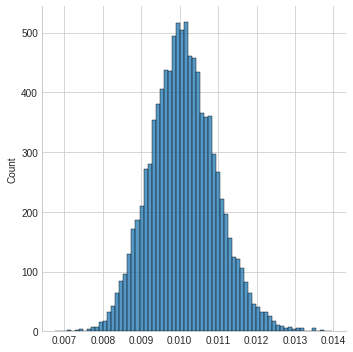

In [102]:
sns.displot(np.stack(eval_losses))

In [124]:
test_recall = []
test_precision = []
window = 25
mse = MSELoss()

vae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = vae(batch)
            mse_loss = mse(reconstructed_batch, batch)
            #kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
            #                                  logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse_loss #+ kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,1.000,1.000000
1,1.000,1.000000
2,0.990,0.994975
3,1.000,1.000000
4,0.775,0.993590
5,1.000,1.000000
6,0.315,0.984375
7,0.870,1.000000
8,0.990,1.000000
9,0.910,0.994536


In [125]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.8992500000000001, 0.9966197716782045)

Per window fault detection with KL divergence

In [71]:
# Per window fault distribution estimation
window = 25
eval_losses = []
mse = MSELoss()

vae.eval()

for k in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[k * window: k * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = vae(batch)

    mse_loss = mse(reconstructed_batch, batch)
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])

    loss = mse_loss + kl_loss

    eval_losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [72]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.1362262501269585

In [73]:
test_recall = []
test_precision = []
window = 25
mse = MSELoss()

vae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = vae(batch)
            mse_loss = mse(reconstructed_batch, batch)
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse_loss + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.235,1.0
1,0.075,1.0
2,0.030,1.0
3,0.035,1.0
4,0.165,1.0
5,0.685,1.0
6,0.285,1.0
7,0.070,1.0
8,0.045,1.0
9,0.050,1.0


In [74]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.1335, 1.0)

TCN

In [88]:
beta

0.1

In [101]:
# Per window fault distribution estimation
window = 25
eval_losses = []
mse = MSELoss()
#row_wise_mse = nn.MSELoss(reduction='none')

vae.eval()

for k in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[k * window: k * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = vae(batch)

    mse_loss = mse(reconstructed_batch, batch)
    #kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
    #                            logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])

    loss = mse_loss #+ kl_loss
        
    eval_losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.01331348776537927

In [22]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.008065741695463657

In [102]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.014031412591226412

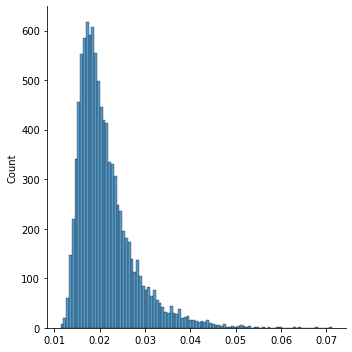

In [91]:
sns.displot(np.stack(eval_losses))

In [92]:
test_recall = []
test_precision = []
window = 25
mse = MSELoss()
autoencoder.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            loss = mse(reconstructed_batch, batch)
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,1.0,0.5
1,1.0,0.5
2,1.0,0.5
3,1.0,0.5
4,1.0,0.5
5,1.0,0.5
6,1.0,0.5
7,1.0,0.5
8,1.0,0.5
9,1.0,0.5


In [27]:
per_fault_loss

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1.

In [25]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.9125000000000002, 1.0)

In [42]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.8839999999999998, 1.0)

In [72]:
beta

1

In [103]:
test_recall = []
test_precision = []
window = 25
mse = MSELoss()

vae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = vae(batch)
            mse_loss = mse(reconstructed_batch, batch)
            #kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
            #                                  logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse_loss #+ kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,1.000,1.000000
1,1.000,1.000000
2,0.985,1.000000
3,1.000,1.000000
4,0.790,0.993711
5,1.000,0.990099
6,0.300,1.000000
7,0.845,0.988304
8,0.995,1.000000
9,0.905,1.000000


In [104]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.899, 0.9973490044412241)

In [158]:
test_recall = []
test_precision = []
window = 64
maxlen = 15000
row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

iterations = 10000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, maxlen)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            per_fault_loss = np.append(per_fault_loss, mse.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.5536,0.534983
1,0.9676,0.673066
2,0.7860,0.625996
3,0.8536,0.645103
4,0.5660,0.544231
5,1.0000,0.677874
6,0.3488,0.424537
7,0.5288,0.526483
8,0.7984,0.629454
9,0.7920,0.627178


In [163]:
sum(per_fault_loss)

3424.0

In [159]:
print(metrics_df.Recall.mean(), metrics_df.Precision.mean())

0.7681600000000002 0.6086678702213214


###Transformer

In [24]:
# Per sample losses distribution
window = 64
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch = autoencoder(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    eval_losses = eval_losses + mse.tolist()

  0%|          | 0/3906 [00:00<?, ?it/s]

In [132]:
!wget https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/models/transformer_ae1.pkl?raw=true -o transformer_ae1.pkl

In [137]:
autoencoder = TAE(encoder, decoder)
autoencoder.load_state_dict(torch.load('transformer_ae1.pkl', map_location=torch.device('cpu')))


<All keys matched successfully>

In [56]:
# Per window fault distribution estimation
window = 25
eval_losses = []
mse = MSELoss()
#row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

for k in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[k * window: k * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch = autoencoder(batch)
        
    loss = mse(reconstructed_batch, batch)
    eval_losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
upper_bound = np.percentile(np.stack(eval_losses), 99.9)
upper_bound

0.008512431443668913

In [58]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.004465696276165545

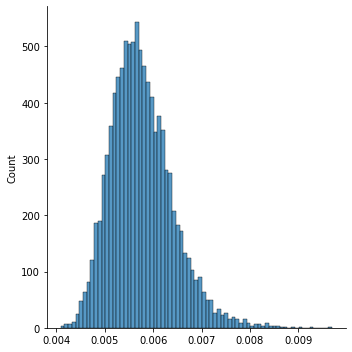

In [59]:
sns.displot(np.stack(eval_losses))

In [28]:
test_recall = []
test_precision = []
window = 64
row_wise_mse = nn.MSELoss(reduction='none')

autoencoder.eval()

iterations = 10000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 15000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            per_fault_loss = np.append(per_fault_loss, mse.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.067416,0.949153
1,0.258026,0.992284
2,0.115169,0.976190
3,0.134831,0.979592
4,0.049759,0.968750
5,0.998796,0.998396
6,0.044141,0.956522
7,0.048154,0.937500
8,0.122793,0.977636
9,0.101124,0.976744


In [60]:
test_recall = []
test_precision = []
window = 25
#row_wise_mse = nn.MSELoss(reduction='none')
mse = MSELoss()
autoencoder.eval()

#iterations = 5000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    windowed_labels = [1 if sum(y_true[k * window: k * window + window]) > 0 else 0 for k in range(len(y_true) // window)]

    per_fault_loss = np.array([])

    for k in range(len(test_faulty) // window):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch = autoencoder(batch)
            loss = mse(reconstructed_batch, batch)
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(windowed_labels, per_fault_loss))
    test_precision.append(precision_score(windowed_labels, per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.340,1.0
1,0.995,1.0
2,0.900,1.0
3,1.000,1.0
4,0.395,1.0
5,1.000,1.0
6,0.250,1.0
7,0.300,1.0
8,0.885,1.0
9,0.555,1.0


In [61]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.74325, 1.0)

In [187]:
test_faulty, y_true = faulty_set(fault, 10000)
len(y_true)

10000

In [190]:
sum(windowed_labels)

87

**Transformer**

In [ ]:
# Per sample losses distribution TCN
beta = 0.5
window = 64
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

tvae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = tvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
    losses = mse + kl_loss
    eval_losses = eval_losses + losses.tolist()

  0%|          | 0/3906 [00:00<?, ?it/s]

In [ ]:
upper_bound = np.percentile(np.stack(eval_losses), 99.99)
upper_bound

0.01898095082100401

In [ ]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.004547412693500519

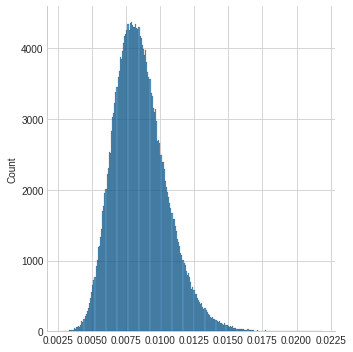

In [ ]:
sns.displot(np.stack(eval_losses))

In [ ]:
test_recall = []
test_precision = []
window = 64
mus = defaultdict(list)
row_wise_mse = nn.MSELoss(reduction='none')
upper_bound = 0.0155

iterations = 5000 // window

tvae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 5000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = tvae(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())
            if k < 100:
                mus[fault].append(mu.cpu().numpy().tolist())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.262440,0.984940
1,0.721108,0.995017
2,0.271669,0.986880
3,0.293740,0.987854
4,0.143660,0.975477
5,1.000000,0.996401
6,0.189406,0.981289
7,0.232343,0.984694
8,0.290931,0.987738
9,0.313804,0.989873


In [ ]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.4134430176565008, 0.9888375740757377)

### Заключение

В работе исследовалась возможность обнаружения аномалий нейросетевыми методами в unsupervised схеме с использованием вариационного автокодировщика. В качестве структурных блоков кодировщика и декодировщика использовались полносвязная сеть (MLP - Nulti-Layer Perceptron) и TCN (Temporal Convolution Network) против результатов baseline-алгоритмов LOF (Local Outlier Factor) и PCA (Principal Component Analysis). 

PCA, MLP и TCN детектируют аномалии по превышению ошибкой некоего порога, выбранного для всех алгоритмов в виде 99.99% перцентиля. Наилучший результат по метрике Recall продемонстрировала модель на основе TCN. Однако, на ошибках №№ 4, 14, 17, 18 и 19 метод РСА оказался лучше остальных. На ошибках 1, 5 и 12 метод на основе TCN в несколько раз превысил Recall других методов. 

Так как верхний порог ошибки везде выбирался одинаковым и очень высоким, то метрики Precision везде оказались близкими к или равными 1. 
Во всех случаях детектирования аномалий методами LOF и РСА метрика Precision оказалась строго равной 1, т.е. False Positives полностью отсутствуют. 

Обучение нейросетевых моделей производилось в схеме Beta-VAE при очень низких значениях Beta = 0.05. Модели со значениеми Beta ниже 0.05 не исследовались и потенциально могут показать результат лучше представленного. Некоторые работы описывают обучение Beta-VAE моделей с коэффициентов Beta, меняющимся пило-образно в некотором диапазоне, что может существенно улучшить результаты моделей на стадии inference. В данной работе такое исследование не проводилось. 

In [ ]:
try:
    from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator
except:
    !git clone https://github.com/airi-industrial-ai/fddbenchmark
    from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

Cloning into 'fddbenchmark'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [ ]:
small_tep = FDDDataset(name='small_tep', splitting_type='supervised')

minmax = MinMaxScaler()

small_tep.df = pd.DataFrame(data=minmax.fit_transform(small_tep.df), index=small_tep.df.index)

test_dl = FDDDataloader(
    dataframe=small_tep.df[small_tep.test_mask],
    labels=small_tep.labels[small_tep.test_mask],
    window_size=64, 
    step_size=64, 
    minibatch_training=True,
    batch_size=1,
)

Downloading: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


In [ ]:
preds = []
labels = []
upper_bound = 0.021 #np.percentile(eval_losses, 55)

tvae.eval()

for test_ts, test_index, test_label in tqdm(test_dl):
    batch = torch.tensor(test_ts).to(torch.float).to(device)
    with torch.no_grad():
        reconstructed_batch, mu, sigma = tvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                          logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
    loss = mse + kl_loss
    
    pred = 1 if torch.any(loss > upper_bound) else 0
    
    preds.append(pd.Series(pred, index=test_index))
    labels.append(test_label)
    
pred = pd.concat(preds)
test_label = pd.concat(labels)

  0%|          | 0/1470 [00:00<?, ?it/s]

In [ ]:
evaluator = FDDEvaluator(
    splitting_type=small_tep.splitting_type, 
    step_size=test_dl.step_size
)

evaluator.print_metrics(test_label, pred)

Detection metrics
-----------------
True Positive Rate (TPR): 0.5158
False Positive Rate (FPR): 0.1185
Average Detection Delay (ADD): 138.11

Diagnosis metrics
-----------------
Correct Diagnosis Rate (CDR):
    Fault 01: 1.0000
    Fault 02: 0.0000
    Fault 03: 0.0000
    Fault 04: 0.0000
    Fault 05: 0.0000
    Fault 06: 0.0000
    Fault 07: 0.0000
    Fault 08: 0.0000
    Fault 09: 0.0000
    Fault 10: 0.0000
    Fault 11: 0.0000
    Fault 12: 0.0000
    Fault 13: 0.0000
    Fault 14: 0.0000
    Fault 15: 0.0000
    Fault 16: 0.0000
    Fault 17: 0.0000
    Fault 18: 0.0000
    Fault 19: 0.0000
    Fault 20: 0.0000
Total Correct Diagnosis Rate (Total CDR): 0.0468
Misdiagnosis Rate (MDR): 0.9532


In [ ]:
upper_bound

0.011431843042373657